In [1]:
import numpy as np
import pandas as pd
import glob
import os
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.table import Table,join
import itertools
from astroquery.simbad import Simbad
from utils import PLOT_PARAMS
PLOT_PARAMS()
from datetime import date
from astropy.coordinates import SkyCoord, EarthLocation

today=date.today()
DATE =today.strftime("%m_%d_%y")
print(DATE)
import pickle
import thejoker as tj
import pymc as pm
import corner
import arviz as az
plt.rcParams['figure.facecolor'] = 'white'
import warnings
warnings.filterwarnings("ignore")

10_20_25


In [2]:
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u

vlt = EarthLocation.of_site('paranal')  # the easiest way... but requires internet

In [3]:
files_p112 = glob.glob('../data/P112_data/*.fits')
files_p113 = glob.glob('../data/P113_data/*.fits')


In [4]:
def get_galah():
    galah =(Table.read('../../lithium/data/GALAH_DR3_main_allstar_v2.fits',format='fits'))#.to_pandas()

    dr2_ids = np.array(galah['dr2_source_id']).astype('str')
    dr3_ids = np.array(galah['dr3_source_id']).astype('str')
    
    galah.remove_column('dr2_source_id')
    galah.remove_column('dr3_source_id')
    galah = galah.to_pandas()

    galah.insert(2, 'dr2_source_id', dr2_ids)
    galah.insert(3, 'dr3_source_id', dr3_ids)
    
    galah['ph_qual_wise']=galah['ph_qual_wise'].str.decode("utf-8")
    return galah
galah=get_galah()

In [5]:
galah_rv = Table.read('/Users/maryumsayeed/Desktop/Code/Research/lithium/data/GALAH_DR3_VAC_rv_v2.fits').to_pandas()

In [6]:
def get_dir(files):
    obj_dir = {}

    counts = []
    for i,file in enumerate(files):
        with fits.open(file) as hdul:
            hdul = fits.open(file)
            header  = hdul[0].header
            #print(header.cards['HIERARCH ESO QC CCF RV ERROR'])
            data    = hdul[1].data
            time    = header['HIERARCH ESO QC BJD']
            name    = header['OBJECT']
            obj     = int(header['HIERARCH ESO OBS NAME'].split('-')[0][2:])
            snr     = header['SNR']
            counts.append(obj)

            grade   = header['OB_GRADE'].replace(" ", "")  
            if grade =='C':
                print('RG',obj,header['OB_GRADE'])
                continue

            ra,dec  = header['RA'], header['DEC']
            obs_T   = header['DATE-OBS'].split('T')[0]
            rv_val  =  header['HIERARCH ESO QC CCF RV']#header['HIERARCH ESO OCS OBJ RV'] #km/s
            rv_err  = header['HIERARCH ESO QC CCF RV ERROR'] #km/s
            sc = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
            rv_corr = rv_val
            err_corr = rv_err

            if obj in obj_dir.keys():
                obj_dir[obj]['rv'].append(rv_corr)
                obj_dir[obj]['time'].append(time)
                obj_dir[obj]['err'].append(err_corr)
                obj_dir[obj]['name'].append(name)
                obj_dir[obj]['grade'].append(grade)
                obj_dir[obj]['snr'].append(snr)

            else:
                obj_dir[obj] = {'rv': [rv_corr], 'time': [time], 'err': [err_corr], 
                                'name': [name], 'grade': [grade], 'snr': [snr]}
          
    targets_to_remove = []
    for k, v in obj_dir.items():
        if len(v['time']) < 3:
            targets_to_remove.append(k)
    for i in range(len(targets_to_remove)):
        del obj_dir[targets_to_remove[i]]
    print(len(obj_dir.keys()))

    myKeys = list(obj_dir.keys())
    myKeys.sort()
    obj_dir = {i: obj_dir[i] for i in myKeys}

    return obj_dir

obj_dir_p112 = get_dir(files_p112)
del obj_dir_p112[13] #13 ended up being a dipper star
obj_dir_p113 = get_dir(files_p113)

RG 20 C
RG 13 C
RG 14 C
RG 1 C
10
RG 12 C
RG 6 C
RG 3 C
RG 11 C
RG 22 C
RG 15 C
RG 3 C
RG 8 C
RG 3 C
RG 25 C
RG 8 C
RG 22 C
RG 3 C
RG 7 C
RG 23 C
25


In [7]:
def combine_table(obj_dir,program):
    new_df = {'RG_id':[], 'galah_id': [], 'obj_name': [], 'esp_time':[],'esp_rv':[],'esp_rv_err':[],
              'program':[]
             }

    for k, v in obj_dir.items():
        if len(v['rv']) < 3: 
            continue
        result_table = Simbad.query_objectids(v['name'][0])
        result_table = np.array(result_table).astype('str')

        for i in result_table:
            if 'GALAH' in i: 
                galah_name = i.split(' ')[-1]

        new_df['RG_id'].append(k)
        new_df['program'].append(program)
        new_df['galah_id'].append(int(galah_name))
        new_df['obj_name'].append(v['name'][0])
        new_df['esp_rv'].append(v['rv'])
        new_df['esp_time'].append(v['time'])
        new_df['esp_rv_err'].append(v['err'])
        
    new_df = pd.DataFrame(new_df)

    cols = ['sobject_id', 'vbroad', 'fe_h', 'e_fe_h' ,'Li_fe', 'e_Li_fe','ruwe_dr2','e_vbroad', 'Ba_fe', 'e_Ba_fe','La_fe','e_La_fe','Zr_fe', 'e_Zr_fe','Y_fe','e_Y_fe']
    new_df = pd.merge(new_df, galah[cols], left_on='galah_id', right_on='sobject_id')
    new_df['Li_val'] = new_df.fe_h+new_df.Li_fe+1.05
    new_df['e_Li_val'] = np.sqrt(new_df.e_fe_h**2.+new_df.e_Li_fe**2.)

    cols = ['RG_id', 'galah_id', 'obj_name', 
            'esp_time','esp_rv','esp_rv_err',
            'Li_val', 'e_Li_val','vbroad','e_vbroad', 'fe_h','ruwe_dr2', 
            'Ba_fe', 'e_Ba_fe','La_fe','e_La_fe','Zr_fe', 'e_Zr_fe','Y_fe','e_Y_fe',
            'program'
           ]
    new_df = new_df[cols]
    new_df.sort_values(by=['RG_id'],inplace=True)
    
    new_df = new_df.round(2)
    return new_df

df_p112 = combine_table(obj_dir_p112,program=112)
df_p113 = combine_table(obj_dir_p113,program=113)


In [8]:
p112_galah = pd.merge(galah[['sobject_id','logg','teff']], df_p112,left_on='sobject_id', right_on='galah_id', how='right')
p113_galah = pd.merge(galah[['sobject_id','logg','teff']], df_p113,left_on='sobject_id', right_on='galah_id', how='right')


In [9]:
df_both = pd.concat([p112_galah, p113_galah])
df_both = pd.merge(df_both, galah[['sobject_id','ra_dr2','dec_dr2','dr3_source_id']],on='sobject_id')
df_both = pd.merge(df_both, galah_rv[['sobject_id','MJD_local','rv_obst','rv_sme_v2','rv_nogr_obst','e_rv_nogr_obst','rv_galah','e_rv_galah','dr2_radial_velocity','use_rv_flag']],on='sobject_id')
df_both[['rv_obst','rv_nogr_obst','rv_sme_v2','rv_galah','use_rv_flag']]


,rv_obst,rv_nogr_obst,rv_sme_v2,rv_galah,use_rv_flag
0,53.551998,53.576000,53.732314,53.551998,0
1,NaN,NaN,29.725057,29.725057,1
2,49.868000,49.931999,49.949126,49.868000,0
3,99.723000,99.746002,99.593048,99.723000,0
4,-4.131000,-4.051000,-4.090244,-4.131000,0
5,3.119000,3.269000,3.496898,3.119000,0
6,23.688000,23.768999,24.118518,23.688000,0
7,5.624000,5.759000,5.588855,5.624000,0
8,25.080000,25.101000,25.801563,25.080000,0
9,-54.818001,-54.791000,-55.053827,-54.818001,0


In [10]:
def convert_mjd_to_jd(mjd):
    t = Time(mjd, format='mjd', scale='local')
    return t.jd

# for i, row in df_both.iterrows():
#     convert_mjd_to_jd(row['MJD_local'])
convert_mjd_to_jd(df_both[df_both['MJD_local']==df_both['MJD_local']]['MJD_local'])

array([2457030.1328125 , 2457675.2578125 , 2457697.20703125,
       2457264.03125   , 2457416.98046875, 2456728.05078125,
       2457887.8671875 , 2456875.90625   , 2457967.96484375,
       2457906.96875   , 2457860.109375  , 2458002.8828125 ,
       2457530.26171875, 2457891.2578125 , 2456846.19921875,
       2457674.86328125, 2457883.1171875 , 2457528.140625  ,
       2456874.91015625, 2457263.86328125, 2457140.94140625,
       2457862.29296875, 2458029.9453125 , 2457966.88671875,
       2457920.015625  , 2457920.015625  , 2457475.28125   ,
       2457538.10546875, 2457533.2421875 , 2458007.8671875 ,
       2457907.203125  ])

In [11]:
def comb_data(df):
    new_df = {'RG_id':[],'sobject_id':[],
              'esp_time': [], 'esp_rv': [], 'esp_rv_err': [],
             }
#               'comb_time':[],'comb_rv':[],'comb_rv_err':[]}

    for i, row in df.iterrows():
        if str(row['MJD_local']) == 'nan':
            galah_bmjd = 'nan'
        else:
            galah_bmjd = convert_mjd_to_jd(row['MJD_local'])
        t = row['esp_time']*1
        r = row['esp_rv']*1
        e = row['esp_rv_err']*1
        
        t, r, e = np.array(t), np.array(r), np.array(e)

        if row.RG_id!=5:
            mask    = (r >= -100)
            t, r, e = t[mask], r[mask], e[mask]
        t, r, e = list(t), list(r), list(e)
        new_df['esp_time'].append(t)
        new_df['esp_rv'].append(r)
        new_df['esp_rv_err'].append(e)

#         t.append(galah_bmjd)
#         r.append(row['rv_galah'])
#         e.append(row['e_rv_galah'])
        
#         mask = [i for i in range(len(t)) if t[i] != 'nan']
#         t, r, e = np.array(t),np.array(r),np.array(e)

        new_df['RG_id'].append(row.RG_id)
        new_df['sobject_id'].append(row.sobject_id)
#         new_df['comb_time'].append(t[mask])
#         new_df['comb_rv'].append(r[mask])
#         new_df['comb_rv_err'].append(e[mask])
        
    new_df = pd.DataFrame(new_df)
    return new_df



In [12]:
def clean_up_rvs(df):
    
    new_df = {'sobject_id':[],'esp_time':[],'esp_rv':[],'esp_rv_err':[]}
    
    for i, row in df.iterrows():
        rv_vals = np.array(row.esp_rv)
        yerr    = np.array(row.esp_rv_err)
        time    = np.array(row.esp_time)
        if row.RG_id!=5:
            mask    = (rv_vals >= -100)
            time, rv_vals, yerr = time[mask], rv_vals[mask], yerr[mask]
            
        new_df['sobject_id'].append(row.sobject_id)
        new_df['esp_time'].append(time)
        new_df['esp_rv'].append(rv_vals)
        new_df['esp_rv_err'].append(yerr)
        if row.program==113 and row.RG_id==14:
            print(rv_vals)
    new_df = pd.DataFrame(new_df)
    return new_df


In [13]:
# new_df = comb_data(df_both)
new_df = clean_up_rvs(df_both)

[-44.02604301 -44.10040724 -44.08746878 -44.18075321 -44.07877018]


In [14]:

df_both_1 = df_both.drop(columns=['esp_time','esp_rv','esp_rv_err'])
comb_df = pd.merge(df_both_1, new_df, on='sobject_id')
comb_df.head(1)


,sobject_id,logg,teff,RG_id,galah_id,obj_name,Li_val,e_Li_val,vbroad,e_vbroad,...,rv_sme_v2,rv_nogr_obst,e_rv_nogr_obst,rv_galah,e_rv_galah,dr2_radial_velocity,use_rv_flag,esp_time,esp_rv,esp_rv_err
0,150107004201104,1.792561,4190.288574,1,150107004201104,UCAC4 297-057956,3.41,0.07,11.29,2.1,...,53.732314,53.576,0.071,53.551998,0.072,53.454258,0,"[2460341.53519178, 2460389.56581584, 2460371.5...","[53.7010931002614, 53.7985038354756, 53.715772...","[0.0356353249891873, 0.0194215970708735, 0.018..."


In [15]:
# comb_df.to_csv('rv_df.csv',index=False)

In [16]:
all_dfs = []

for i, row in comb_df.iterrows():
    N      = np.array(row.esp_time)
    ids    = [row.sobject_id]*len(N)
    source = ['ESPRESSO']*len(N)
    
    dat1   = pd.DataFrame({'GALAH_ID':ids,
                        'time':np.array(row.esp_time).astype(str), 
                        'rv':np.array(row.esp_rv).astype(str),  
                        'rv_err':np.array(row.esp_rv_err).astype(str),
                        'source':source
                       })

    N      = np.array([row.rv_galah])
    ids    = [row.sobject_id]*len(N)
    source = ['GALAH']*len(N)
    time = row.MJD_local

    if time != time:
        new_time = np.nan
    else:
        new_time = convert_mjd_to_jd(time)

    
    dat2   = pd.DataFrame({'GALAH_ID':ids,
                        'time':np.array(new_time).astype(str),   
                        'rv':np.array(row.rv_galah).astype(str),  
                        'rv_err':np.array(row.e_rv_galah).astype(str),
                        'source':source
                       })
    
    dat = pd.concat([dat1, dat2])
    all_dfs.append(dat)


In [17]:
pd.concat(all_dfs)#[pd.concat(all_dfs)['GALAH_ID']==150829002601352]


,GALAH_ID,time,rv,rv_err,source
0,150107004201104,2460341.53519178,53.7010931002614,0.0356353249891873,ESPRESSO
1,150107004201104,2460389.56581584,53.7985038354756,0.0194215970708735,ESPRESSO
2,150107004201104,2460371.51348333,53.7157728358864,0.01884311301645,ESPRESSO
3,150107004201104,2460303.84853621,53.4587722172283,0.0061571780501783,ESPRESSO
0,150107004201104,2457030.1328125,53.551998138427734,0.07199999690055847,GALAH
...,...,...,...,...,...
1,170602005701107,2460515.80706696,17.4670312869741,0.0174777475111209,ESPRESSO
2,170602005701107,2460475.85801927,17.4843381279954,0.0307488082563063,ESPRESSO
3,170602005701107,2460500.77682604,17.4963712771897,0.0193392923640643,ESPRESSO
4,170602005701107,2460534.66546042,17.4716289065662,0.0242902191322107,ESPRESSO


In [18]:
#pd.concat(all_dfs).to_csv('rv_table.csv',index=False)

In [19]:
comb_df[(comb_df.program==113) & (comb_df.RG_id == 14)].esp_rv.values


array([array([-44.02604301, -44.10040724, -44.08746878, -44.18075321,
              -44.07877018])                                         ],
      dtype=object)

In [20]:
comb_df_tb = Table.from_pandas(comb_df)
comb_df_tb['dr3_source_id'] = comb_df_tb['dr3_source_id'].astype(int)

In [21]:
def convert_time_to_jd(time):
    from datetime import datetime
    from astropy.time import Time

    # Create a datetime object
    dt = datetime.strptime(time, "%Y%m%d")

    # Convert the datetime object to an astropy Time object
    t = Time(dt, format='datetime', scale='utc')
    
    # Access the Modified Julian Date (MJD)
    jd = t.jd
    
    return jd

In [22]:
rave = Table.read('/Users/maryumsayeed/Downloads/rave_crossmatch.fits')

In [23]:
joined = join(rave,comb_df_tb,keys_left='source_id',keys_right='dr3_source_id')#
joined['rave_obsdate'] = [i.split('_')[0] for i in joined['rave_obs_id']]
joined['rave_jd']     = [convert_time_to_jd(i) for i in joined['rave_obsdate']]
joined['source']       = ['RAVE']*len(joined)

rave_joined = pd.DataFrame({'GALAH_ID':joined['sobject_id'] ,
                            'time':joined['rave_jd'] ,
                            'rv':joined['hrv_sparv'] ,
                            'rv_err':joined['hrv_error_sparv'] ,
                            'source':joined['source'] ,
                           })

esp_galah = pd.concat(all_dfs)
esp_galah_rave = pd.concat([esp_galah,rave_joined])


In [24]:
apogee_dr17 = {
    'GALAH_ID' : [150428000601308,151230003202196,140707003101315,140707003101315],
    'time' : [2458646.67558,2458827.64986,2458732.79792,2458731.78777],
    'rv': [27.24648666381836,33.2837028503418,-44.76622461216243,-44.57581773079781],
    'rv_err':[0.027553709223866463,0.029930321499705315,0.05547336542377407,0.058634062254277884],
    'source': ['APOGEE', 'APOGEE','APOGEE','APOGEE']
}

apogee_dr17 = pd.DataFrame(apogee_dr17)
esp_galah_rave_apogee = pd.concat([esp_galah_rave,apogee_dr17 ])

esp_galah_rave_apogee = esp_galah_rave_apogee.sort_values(by=['GALAH_ID','source'])

# esp_galah_rave_apogee.to_csv('combined_rvs.csv',index=False)
esp_galah_rave_apogee

,GALAH_ID,time,rv,rv_err,source
0,140311007101261,2460388.49997333,23.5296422600186,0.0497316920164264,ESPRESSO
1,140311007101261,2460303.83889431,23.3061153528581,0.0188699131292371,ESPRESSO
2,140311007101261,2460344.87493264,23.2354793778402,0.0516786488909455,ESPRESSO
0,140311007101261,2456728.05078125,23.687999725341797,0.0820000022649765,GALAH
2,140707003101315,2458732.79792,-44.766225,0.055473,APOGEE
...,...,...,...,...,...
1,171003002601363,2460467.92056254,-33.5997486540806,0.0326921304472577,ESPRESSO
2,171003002601363,2460500.90336201,-33.7081848901936,0.0492143299110572,ESPRESSO
3,171003002601363,2460443.90797462,-33.5576465070852,0.0329745456465757,ESPRESSO
4,171003002601363,2460427.904157,-33.5284713033847,0.0401656022170961,ESPRESSO


[23.52964226 23.30611535 23.23547938] [23.68799973]
[0.04973169 0.01886991 0.05167865] [0.082]


[-44.4442598  -44.50548853 -44.12095429 -44.4301628  -44.96346128] [-44.79600143]
[0.05024103 0.05054062 0.06273943 0.04256826 0.06994483] [0.112]


[-29.76431485 -29.68571797 -29.79159169 -29.77984853 -29.83160714] [-29.78700066]
[0.01222511 0.0123673  0.01082915 0.01321859 0.00844034] [0.098]


[25.04572528 25.05686891 24.45786337 25.04092225 25.1447924 ] [25.07999992]
[0.06439894 0.06377488 0.06951641 0.07039171 0.06755511] [0.112]


[53.7010931  53.79850384 53.71577284 53.45877222] [53.55199814]
[0.03563532 0.0194216  0.01884311 0.00615718] [0.072]


[27.55393218 27.51319025 27.58416651 27.57719069] [27.18899918]
[0.01060732 0.01119541 0.00894179 0.00791214] [0.05]


[47.49716689 47.52484846 47.40947162 47.74194174 47.420412  ] [48.59182945]
[0.08150657 0.06627403 0.08138621 0.0750325  0.0746232 ] [0.36771336]


[-44.02604301 -44.10040724 -44.08746878 -44.18075321 -44.07877018] [-44.319

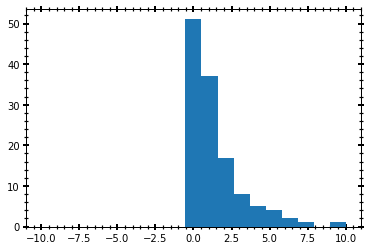

In [25]:

# sources = np.unique(esp_galah_rave_apogee['source'])
all_galah = []
for i in np.unique(esp_galah_rave_apogee['GALAH_ID']):
    grouped = esp_galah_rave_apogee[esp_galah_rave_apogee.GALAH_ID==i]
    esp_rv  = np.array(grouped[grouped.source=='ESPRESSO']['rv'].values).astype(float)
    esp_err = np.array(grouped[grouped.source=='ESPRESSO']['rv_err'].values).astype(float)


    o_rv = np.array(grouped[grouped.source=='GALAH']['rv'].values).astype(float)
    o_err = np.array(grouped[grouped.source=='GALAH']['rv_err'].values).astype(float)
    #print(esp_rv)
    #print(esp_err)
    #print( o_rv, o_err)
#     plt.figure()
    print(esp_rv,o_rv)
    print(esp_err, o_err)
    print('\n')
    all_galah.append(((esp_rv - o_rv)**2 / (np.sqrt(o_err**2. + esp_err**2.))))
all_galah = [item for sublist in all_galah for item in sublist]
_=plt.hist(all_galah,bins=np.linspace(-10,10,20))
# np.mean(all_galah)

In [31]:
paper_table = esp_galah_rave_apogee.copy()
for c in ['time','rv','rv_err']:    
    paper_table[c] = paper_table[c].astype(float)

paper_table.to_csv('../submission/Table2.csv',index=False)

paper_table['time'] = paper_table['time'].round(1)
paper_table['rv'] = paper_table['rv'].round(1)
paper_table['rv_err'] = 1000*paper_table['rv_err']#.round(1)

paper_table['rv_err'] = ['%i' % i for i in paper_table['rv_err']]
print(paper_table.head(20).to_latex(index=False,float_format="{:.2f}".format))

paper_table.keys()

\begin{tabular}{rrrll}
\toprule
GALAH_ID & time & rv & rv_err & source \\
\midrule
140311007101261 & 2460388.50 & 23.50 & 49 & ESPRESSO \\
140311007101261 & 2460303.80 & 23.30 & 18 & ESPRESSO \\
140311007101261 & 2460344.90 & 23.20 & 51 & ESPRESSO \\
140311007101261 & 2456728.10 & 23.70 & 82 & GALAH \\
140707003101315 & 2458732.80 & -44.80 & 55 & APOGEE \\
140707003101315 & 2458731.80 & -44.60 & 58 & APOGEE \\
140707003101315 & 2460473.90 & -44.40 & 50 & ESPRESSO \\
140707003101315 & 2460458.90 & -44.50 & 50 & ESPRESSO \\
140707003101315 & 2460534.70 & -44.10 & 62 & ESPRESSO \\
140707003101315 & 2460493.90 & -44.40 & 42 & ESPRESSO \\
140707003101315 & 2460517.60 & -45.00 & 69 & ESPRESSO \\
140707003101315 & 2456846.20 & -44.80 & 112 & GALAH \\
140805001501346 & 2460435.70 & -29.80 & 12 & ESPRESSO \\
140805001501346 & 2460453.80 & -29.70 & 12 & ESPRESSO \\
140805001501346 & 2460499.70 & -29.80 & 10 & ESPRESSO \\
140805001501346 & 2460516.60 & -29.80 & 13 & ESPRESSO \\
140805001501346 & 

Index(['GALAH_ID', 'time', 'rv', 'rv_err', 'source'], dtype='object')

In [27]:
ss

NameError: name 'ss' is not defined

In [ ]:
comb_df[comb_df.sobject_id==150428000601308]['program']

In [ ]:
ss

In [ ]:
def make_plot(df):
    plt.figure(figsize=(8,30))
    for i, row in df.iterrows():
        rv_vals = np.array(row.comb_rv)
        yerr    = np.array(row.comb_rv_err)
        time    = np.array(row.comb_time)

        t2 = Time(time, format='jd')

        bmjd2 = t2.tcb.mjd

        bmjd2 = bmjd2 - min(bmjd2)
        plt.subplot(17,2,i+1)
        plt.scatter(bmjd2,rv_vals)

        peak = max(rv_vals) - min(rv_vals)
        plt.title('RG%s (%s) - %.1f'%(row.RG_id, row.program, peak),fontsize=8)
    plt.tight_layout()
    plt.show()
make_plot(comb_df)

In [ ]:
cols = ['sobject_id', 'dr3_source_id','ra_dr2', 'dec_dr2','obj_name','logg', 'teff',  'Li_val', 'vbroad', 'fe_h', 
        'ruwe_dr2']
# both[cols].to_csv('espresso_targets.csv',index=False)